## 0. Find lesions & 3D Reconstruction

In [22]:
import os
import numpy as np
import pydicom
from skimage import measure

# 데이터 폴더 경로
data_folder = "C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen"

# 병변을 나타내는 색상들의 RGB 값
lesion_colors = np.array([
    [255, 0, 0],      # Red
    [255, 255, 0],    # Yellow1
    [255, 102, 0],   # Yellow2
    [0, 102, 255],  # Blue1
    [0, 0, 255],  # Blue2
    [0, 255, 0],      # Green
    [128, 0, 255]     # Purple
])

# DICOM 파일들을 읽고 이미지 데이터를 가져오는 함수
def load_patient_images(patient_folder):
    # patient_folder 내의 DICOM 파일들을 가져오기
    dicom_files = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.endswith('.dcm')]

    # DICOM 파일들을 읽기
    dicoms = [pydicom.dcmread(d) for d in dicom_files]

    # 각 DICOM 파일의 이미지 위치 정보를 기준으로 정렬
    dicoms.sort(key=lambda d: float(d.ImagePositionPatient[2]))

    # 각 DICOM 파일의 pixel_array를 가져오기
    images = np.stack([d.pixel_array for d in dicoms])

    return images

# 병변 영역을 찾는 함수
def find_lesions(images):
    lesion_mask = np.any([np.all(images == color, axis=-1) for color in lesion_colors], axis=0)
    return lesion_mask

# 가장 큰 병변의 Bounding Volume을 찾는 함수
def find_largest_lesion_and_bounding_volume(lesion_mask):
    # 3D Connected Component Labeling 수행
    labels = measure.label(lesion_mask)

    # 각 병변의 크기를 계산하고 가장 큰 병변을 찾기
    sizes = np.bincount(labels.ravel())
    max_label = sizes[1:].argmax() + 1  # 0 레이블은 배경이므로 제외

    # 가장 큰 병변에 해당하는 픽셀들의 좌표를 찾기
    lesion_pixels = np.where(labels == max_label)

    # bounding volume의 모서리를 찾기
    min_corner = np.array([np.min(i) for i in lesion_pixels])
    max_corner = np.array([np.max(i) for i in lesion_pixels])

    return min_corner, max_corner

## 002 patient check(sample)

In [23]:
# 002번 환자 폴더에서 실행
patient_folder_name = str(2).zfill(3)
patient_folder_path = os.path.join(data_folder, patient_folder_name)

# 'cad'가 이름에 들어간 폴더 찾기
cad_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'cad' in f.lower()][0]

# cad 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder = [os.path.join(cad_folder, f) for f in os.listdir(cad_folder) if os.path.isdir(os.path.join(cad_folder, f))][0]

# DICOM 이미지들을 로드하기
images = load_patient_images(dicom_folder)

# 환자의 이미지 개수 출력
print(f"환자 {patient_folder_name}의 DICOM 이미지 개수: {len(images)}장")

# 병변 마스크를 생성하기
lesion_mask = find_lesions(images)

# 가장 큰 병변의 Bounding Volume 찾기
min_corner, max_corner = find_largest_lesion_and_bounding_volume(lesion_mask)

# 전체 3D 볼륨의 모서리를 구하기
total_min_corner = np.array([0, 0, 0])
total_max_corner = np.array(images.shape) - 1

# Bounding Volume 및 전체 볼륨의 정보를 출력
print(f"환자 {patient_folder_name}의 가장 큰 병변의 Bounding Volume:")
print(f"  Min corner: {min_corner}")
print(f"  Max corner: {max_corner}")
print(f"환자 {patient_folder_name}의 전체 3D 볼륨의 크기:")
print(f"  최소 모서리: {total_min_corner}")
print(f"  최대 모서리: {total_max_corner}")

환자 002의 DICOM 이미지 개수: 180장
환자 002의 가장 큰 병변의 Bounding Volume:
  Min corner: [ 34 319 322]
  Max corner: [ 90 345 421]
환자 002의 전체 3D 볼륨의 크기:
  최소 모서리: [0 0 0]
  최대 모서리: [179 575 575   2]


## visualize_sample

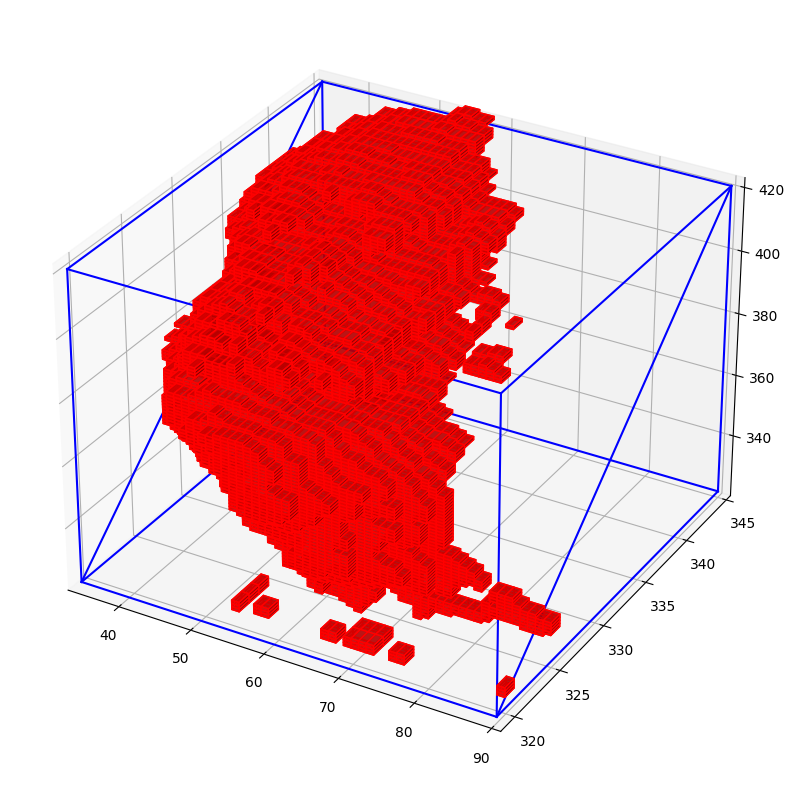

In [25]:
import matplotlib.pyplot as plt

def draw_bounding_box(ax, min_corner, max_corner):
    # 가로 선을 그립니다.
    for z in [min_corner[2], max_corner[2]]:
        ax.plot([min_corner[0], max_corner[0]], [min_corner[1], min_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], max_corner[0]], [max_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], min_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')

    # 세로 선을 그립니다.
    for y in [min_corner[1], max_corner[1]]:
        ax.plot([min_corner[0], min_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
    for x in [min_corner[0], max_corner[0]]:
        ax.plot([x, x], [min_corner[1], max_corner[1]], [min_corner[2], max_corner[2]], 'b-')
        
def visualize_lesion_and_bounding_box(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 병변 영역을 잘라내고, 원래 있던 위치에 넣습니다.
    lesion_volume = lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1]
    filled = np.zeros_like(lesion_mask)
    filled[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1] = lesion_volume
    ax.voxels(filled, facecolors='r', edgecolor='r', alpha=0.7)

    # 바운딩 박스를 그립니다.
    draw_bounding_box(ax, min_corner, max_corner)

    # 축 범위를 설정합니다.
    ax.set_xlim(min_corner[0], max_corner[0])
    ax.set_ylim(min_corner[1], max_corner[1])
    ax.set_zlim(min_corner[2], max_corner[2])

    plt.show()

# 가장 큰 병변과 그 바운딩 박스를 3D로 시각화합니다.
visualize_lesion_and_bounding_box(lesion_mask, min_corner, max_corner)

## 1. Extract 3D-ROI from precontrast_data

In [46]:
# DICOM 파일들을 읽고 이미지 데이터를 가져오는 함수
def load_dicoms(patient_folder):
    # patient_folder 내의 DICOM 파일들을 가져오기
    dicom_files = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.endswith('.dcm')]

    # DICOM 파일들을 읽기
    dicoms = [pydicom.dcmread(d) for d in dicom_files]

    # 각 DICOM 파일의 이미지 위치 정보를 기준으로 정렬
    dicoms.sort(key=lambda d: float(d.ImagePositionPatient[2]))

    # 각 DICOM 파일의 pixel_array를 가져오기
    images = np.stack([d.pixel_array for d in dicoms])

    return images, dicoms

# images를 3D 복셀로 변환합니다.
def create_voxel(images, dicoms):
    # 모든 2D DICOM 이미지를 하나의 3D numpy 배열로 결합
    voxel = images.astype(float)

    # DICOM 파일의 RescaleIntercept와 RescaleSlope를 적용하여 픽셀 값 조정
    voxel *= np.float64(dicoms[0].RescaleSlope)
    voxel += np.float64(dicoms[0].RescaleIntercept)

    return voxel

def visualize_bounding_box_volume(volume, min_corner, max_corner):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 병변 영역을 잘라내고, 원래 있던 위치에 넣습니다.
    volume_section = volume[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1]
    filled = np.zeros_like(volume)
    filled[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1] = volume_section
    ax.voxels(filled, facecolors='b', edgecolor='b', alpha=0.05)  # 수정된 부분

    # 축 범위를 설정합니다.
    ax.set_xlim(min_corner[0], max_corner[0])
    ax.set_ylim(min_corner[1], max_corner[1])
    ax.set_zlim(min_corner[2], max_corner[2])

    plt.show()

In [39]:
# 'precontrast'가 이름에 들어간 폴더 찾기
precontrast_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'precontrast' in f.lower()][0]

# precontrast 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder_pre = [os.path.join(precontrast_folder, f) for f in os.listdir(precontrast_folder) if os.path.isdir(os.path.join(precontrast_folder, f))][0]

# DICOM 이미지를 로드하기
images_pre, dicoms_pre = load_dicoms(dicom_folder_pre)

# images_pre를 3D 복셀로 변환합니다.
voxels_pre = create_voxel(images_pre, dicoms_pre)

In [41]:
print("Voxel shape:", voxels_pre.shape)
print("Voxel min:", voxels_pre.min())
print("Voxel max:", voxels_pre.max())
print("Voxel mean:", voxels_pre.mean())
print("Voxel std:", voxels_pre.std())

Voxel shape: (180, 576, 576)
Voxel min: 0.0
Voxel max: 4162.973137973137
Voxel mean: 203.17321706270627
Voxel std: 397.7775790642379


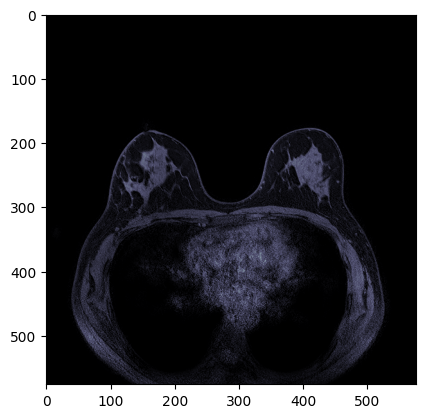

In [42]:
import matplotlib.pyplot as plt

# 중간 슬라이스를 선택합니다.
middle_slice = voxels_pre[len(voxels_pre) // 2]

# 이미지를 표시합니다.
plt.imshow(middle_slice, cmap=plt.cm.bone, vmin=voxels_pre.min(), vmax=voxels_pre.max())
plt.show()

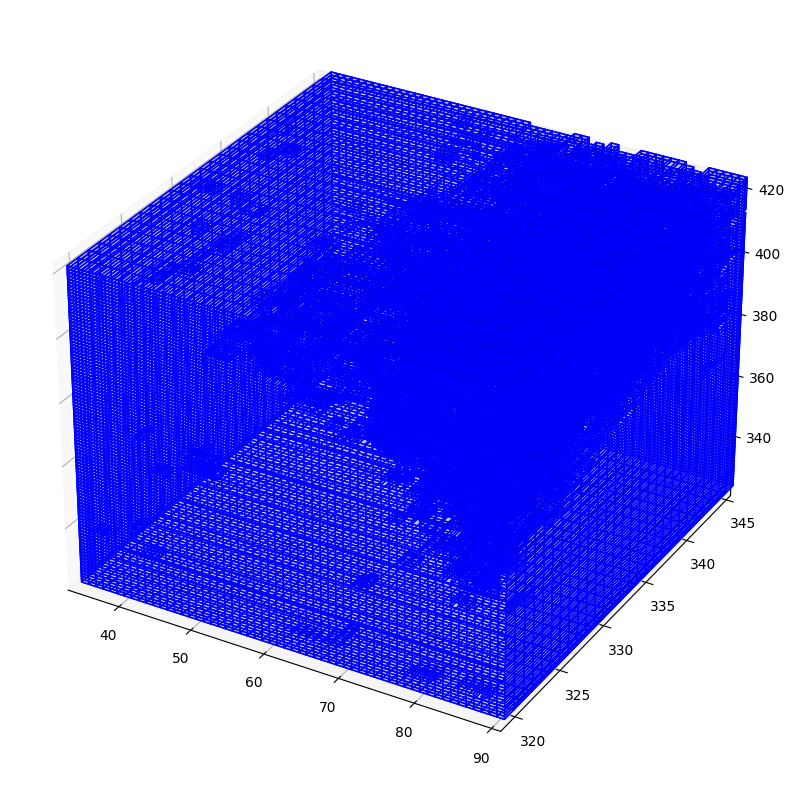

In [45]:
# precontrast 병변 부분을 3D로 시각화합니다.
visualize_bounding_box_volume(voxels_pre, min_corner, max_corner)

## 2. Extract 3D-ROI from FPE_data

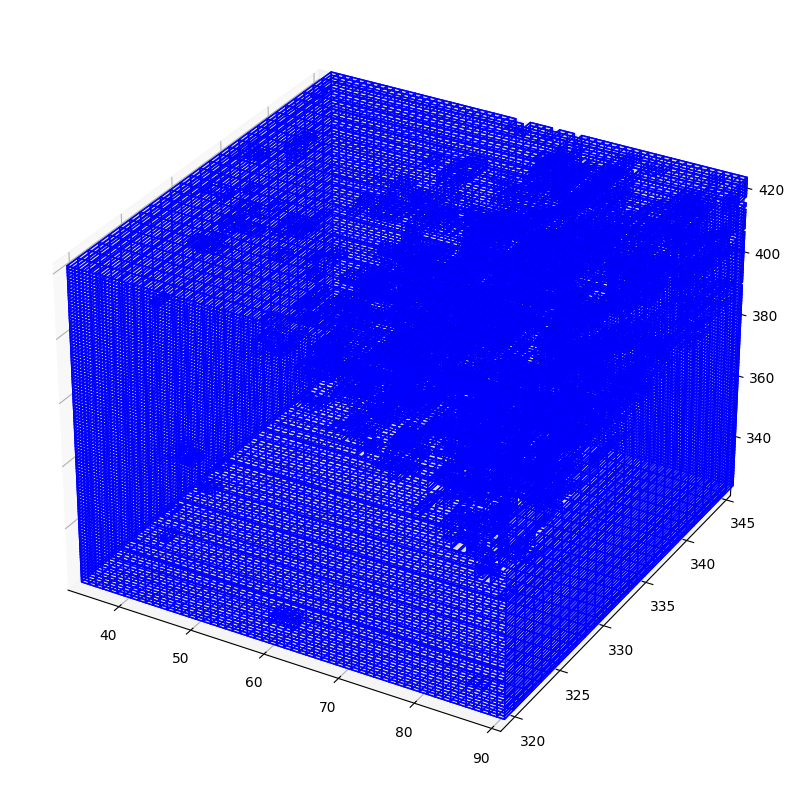

In [47]:
# 'fast'가 이름에 들어간 폴더 찾기
fpe_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'fast' in f.lower()][0]

# fpe 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder_fpe = [os.path.join(fpe_folder, f) for f in os.listdir(fpe_folder) if os.path.isdir(os.path.join(fpe_folder, f))][0]

# DICOM 이미지를 로드하기
images_fpe, dicoms_fpe = load_dicoms(dicom_folder_fpe)

# images_fpe를 3D 복셀로 변환합니다.
voxels_fpe = create_voxel(images_fpe, dicoms_fpe)

# precontrast 병변 부분을 3D로 시각화합니다.
visualize_bounding_box_volume(voxels_fpe, min_corner, max_corner)

## 3. Extract 3D-ROI from DE_data

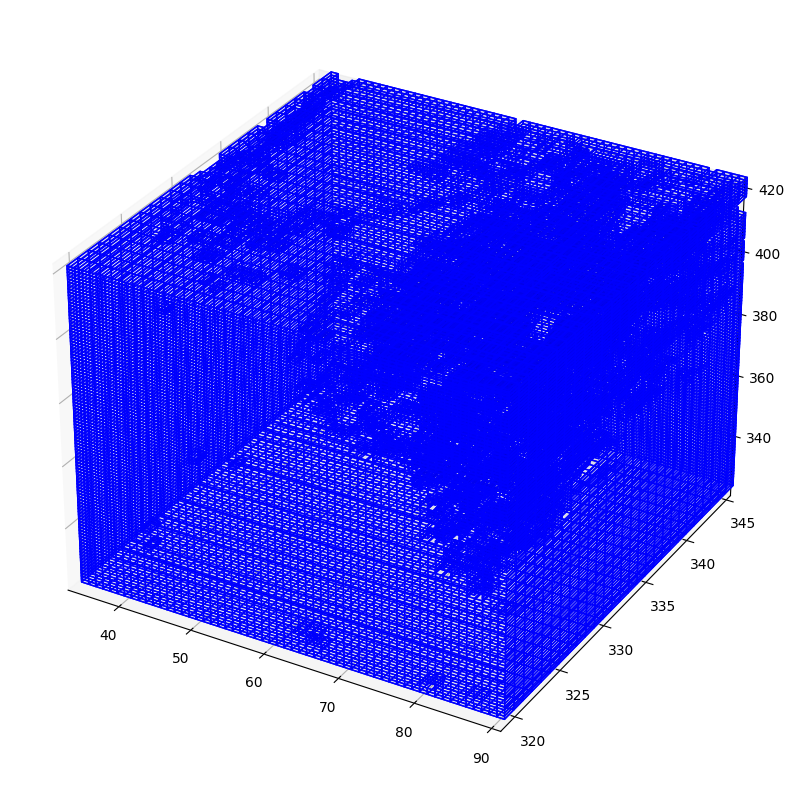

In [48]:
# 'delay'가 이름에 들어간 폴더 찾기
de_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'delay' in f.lower()][0]

# precontrast 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder_de = [os.path.join(de_folder, f) for f in os.listdir(de_folder) if os.path.isdir(os.path.join(de_folder, f))][0]

# DICOM 이미지를 로드하기
images_de, dicoms_de = load_dicoms(dicom_folder_de)

# images_pre를 3D 복셀로 변환합니다.
voxels_de = create_voxel(images_de, dicoms_de)

# precontrast 병변 부분을 3D로 시각화합니다.
visualize_bounding_box_volume(voxels_de, min_corner, max_corner)

In [51]:
# 병변 영역을 잘라내기
volume_section = voxels_de[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1]

# 병변 영역의 shape 출력
print(f"Bounding box volume shape: {volume_section.shape}")

Bounding box volume shape: (57, 27, 100)


## Checking some materials

In [1]:
import importlib

packages = ['pydicom', 'skimage', 'mpl_toolkits.mplot3d', 'matplotlib.pyplot']

for package in packages:
    try:
        importlib.import_module(package)
        print(f"{package} is installed.")
    except ImportError:
        print(f"{package} is not installed.")

pydicom is installed.
skimage is installed.
mpl_toolkits.mplot3d is installed.
matplotlib.pyplot is installed.


In [2]:
import os
import pydicom

data_folder = "C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast"

dicom_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.dcm')]

for dicom_file in dicom_files:
    try:
        d = pydicom.dcmread(dicom_file)
        print(f"Successfully read {dicom_file}")
    except:
        print(f"Failed to read {dicom_file}")

Successfully read C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00001.dcm
Successfully read C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00002.dcm
Successfully read C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00003.dcm
Successfully read C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00004.dcm
Successfully read C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_201512

In [3]:
for dicom_file in dicom_files:
    d = pydicom.dcmread(dicom_file)
    
    if 'ImagePositionPatient' in d and 'PixelSpacing' in d:
        print(f"{dicom_file} contains necessary metadata")
    else:
        print(f"{dicom_file} does not contain necessary metadata")

C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00001.dcm contains necessary metadata
C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00002.dcm contains necessary metadata
C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00003.dcm contains necessary metadata
C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00004.dcm contains necessary metadata
C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25

In [4]:
series_uids = [pydicom.dcmread(dicom_file).SeriesInstanceUID for dicom_file in dicom_files]

if len(set(series_uids)) > 1:
    print("DICOM files belong to different series")
else:
    print("All DICOM files belong to the same series")

All DICOM files belong to the same series


In [5]:
for dicom_file in dicom_files:
    d = pydicom.dcmread(dicom_file)
    
    try:
        pixel_array = d.pixel_array
        print(f"'pixel_array' in {dicom_file} has shape {pixel_array.shape}")
    except Exception as e:
        print(f"Failed to access 'pixel_array' in {dicom_file}: {e}")

'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00001.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00002.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00003.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00004.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classi

'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00135.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00136.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00137.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast\FILE00138.dcm has shape (576, 576, 3)
'pixel_array' in C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classi

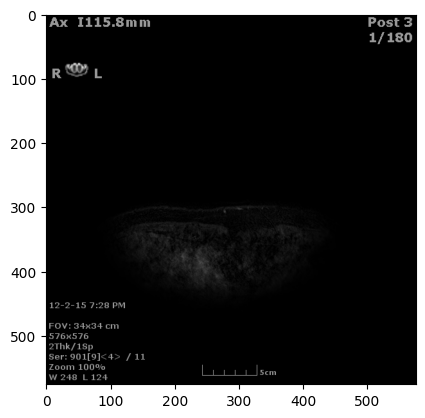

In [6]:
import matplotlib.pyplot as plt

# Select a file to visualize
dicom_file = dicom_files[0]
d = pydicom.dcmread(dicom_file)
pixel_array = d.pixel_array

plt.imshow(pixel_array, cmap='gray')
plt.show()

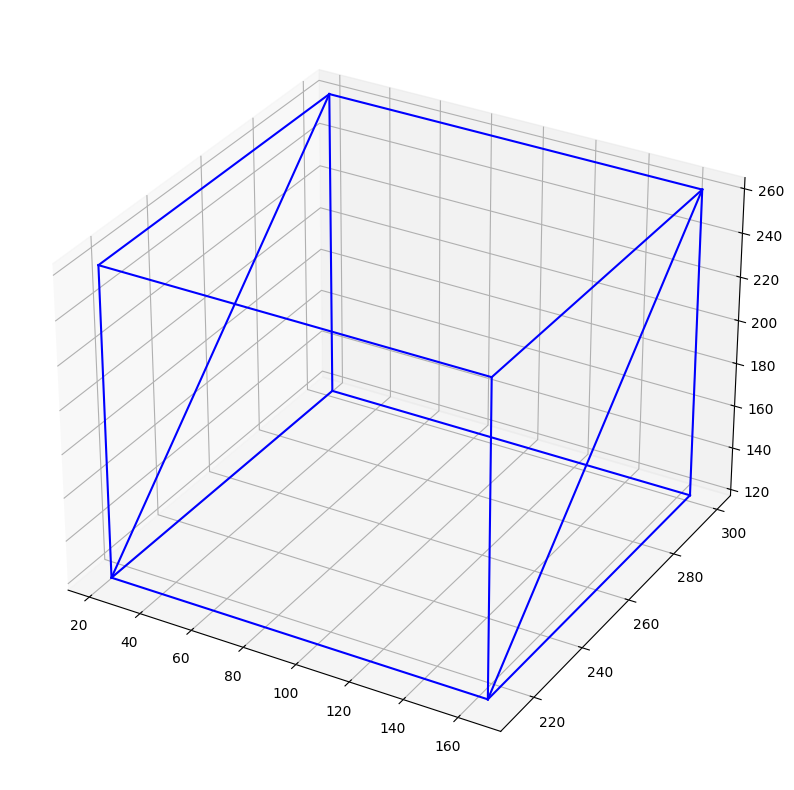

In [12]:
import matplotlib.pyplot as plt

def draw_bounding_box(ax, min_corner, max_corner):
    # 가로 선을 그립니다.
    for z in [min_corner[2], max_corner[2]]:
        ax.plot([min_corner[0], max_corner[0]], [min_corner[1], min_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], max_corner[0]], [max_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], min_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')

    # 세로 선을 그립니다.
    for y in [min_corner[1], max_corner[1]]:
        ax.plot([min_corner[0], min_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
    for x in [min_corner[0], max_corner[0]]:
        ax.plot([x, x], [min_corner[1], max_corner[1]], [min_corner[2], max_corner[2]], 'b-')


def visualize_bounding_box(min_corner, max_corner):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    draw_bounding_box(ax, min_corner, max_corner)
    plt.show()

# Bounding Box 시각화
visualize_bounding_box(min_corner, max_corner)

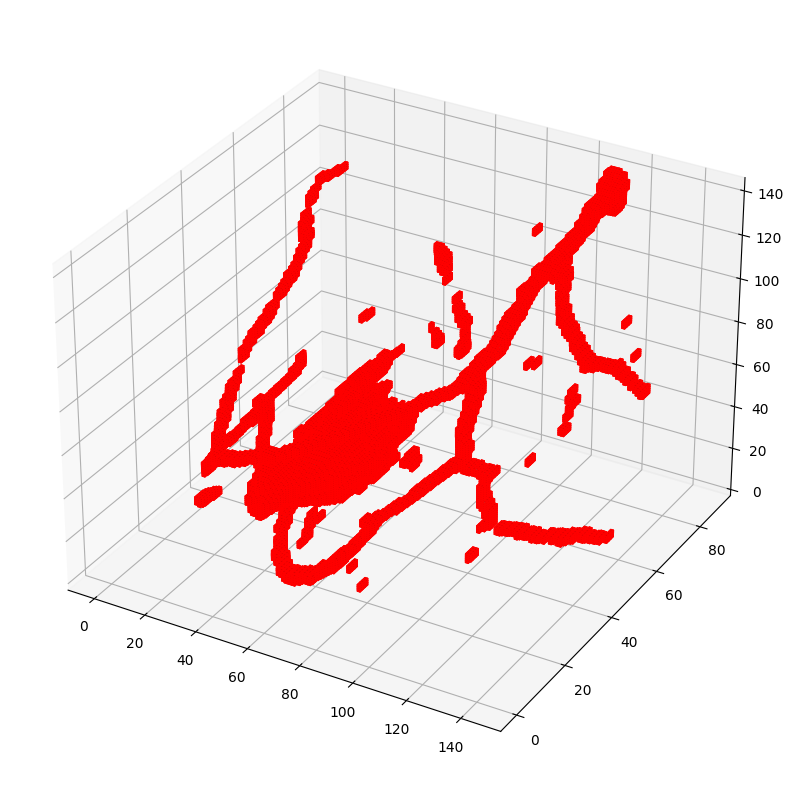

In [16]:
import matplotlib.pyplot as plt

def visualize_lesion_volume(lesion_mask, min_corner, max_corner):
    # 병변 영역을 잘라냅니다.
    lesion_volume = lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1]
    
    # 3D 그래프를 생성합니다.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 병변 부분만 3D로 표현합니다.
    ax.voxels(lesion_volume, facecolors='r', edgecolor='r', alpha=0.5)
    
    plt.show()

# 가장 큰 병변의 3D 시각화
visualize_lesion_volume(lesion_mask, min_corner, max_corner)

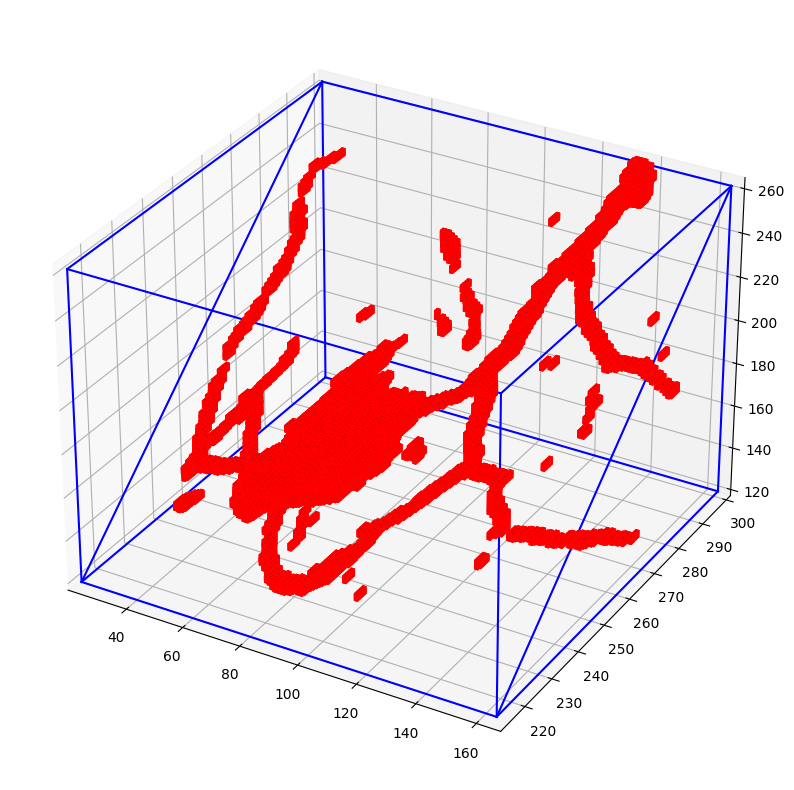

In [21]:
import matplotlib.pyplot as plt

def draw_bounding_box(ax, min_corner, max_corner):
    # 가로 선을 그립니다.
    for z in [min_corner[2], max_corner[2]]:
        ax.plot([min_corner[0], max_corner[0]], [min_corner[1], min_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], max_corner[0]], [max_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], min_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')

    # 세로 선을 그립니다.
    for y in [min_corner[1], max_corner[1]]:
        ax.plot([min_corner[0], min_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
    for x in [min_corner[0], max_corner[0]]:
        ax.plot([x, x], [min_corner[1], max_corner[1]], [min_corner[2], max_corner[2]], 'b-')
        
def visualize_lesion_and_bounding_box(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 병변 영역을 잘라내고, 원래 있던 위치에 넣습니다.
    lesion_volume = lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1]
    filled = np.zeros_like(lesion_mask)
    filled[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1] = lesion_volume
    ax.voxels(filled, facecolors='r', edgecolor='r', alpha=0.7)

    # 바운딩 박스를 그립니다.
    draw_bounding_box(ax, min_corner, max_corner)

    # 축 범위를 설정합니다.
    ax.set_xlim(min_corner[0], max_corner[0])
    ax.set_ylim(min_corner[1], max_corner[1])
    ax.set_zlim(min_corner[2], max_corner[2])

    plt.show()

# 가장 큰 병변과 그 바운딩 박스를 3D로 시각화합니다.
visualize_lesion_and_bounding_box(lesion_mask, min_corner, max_corner)

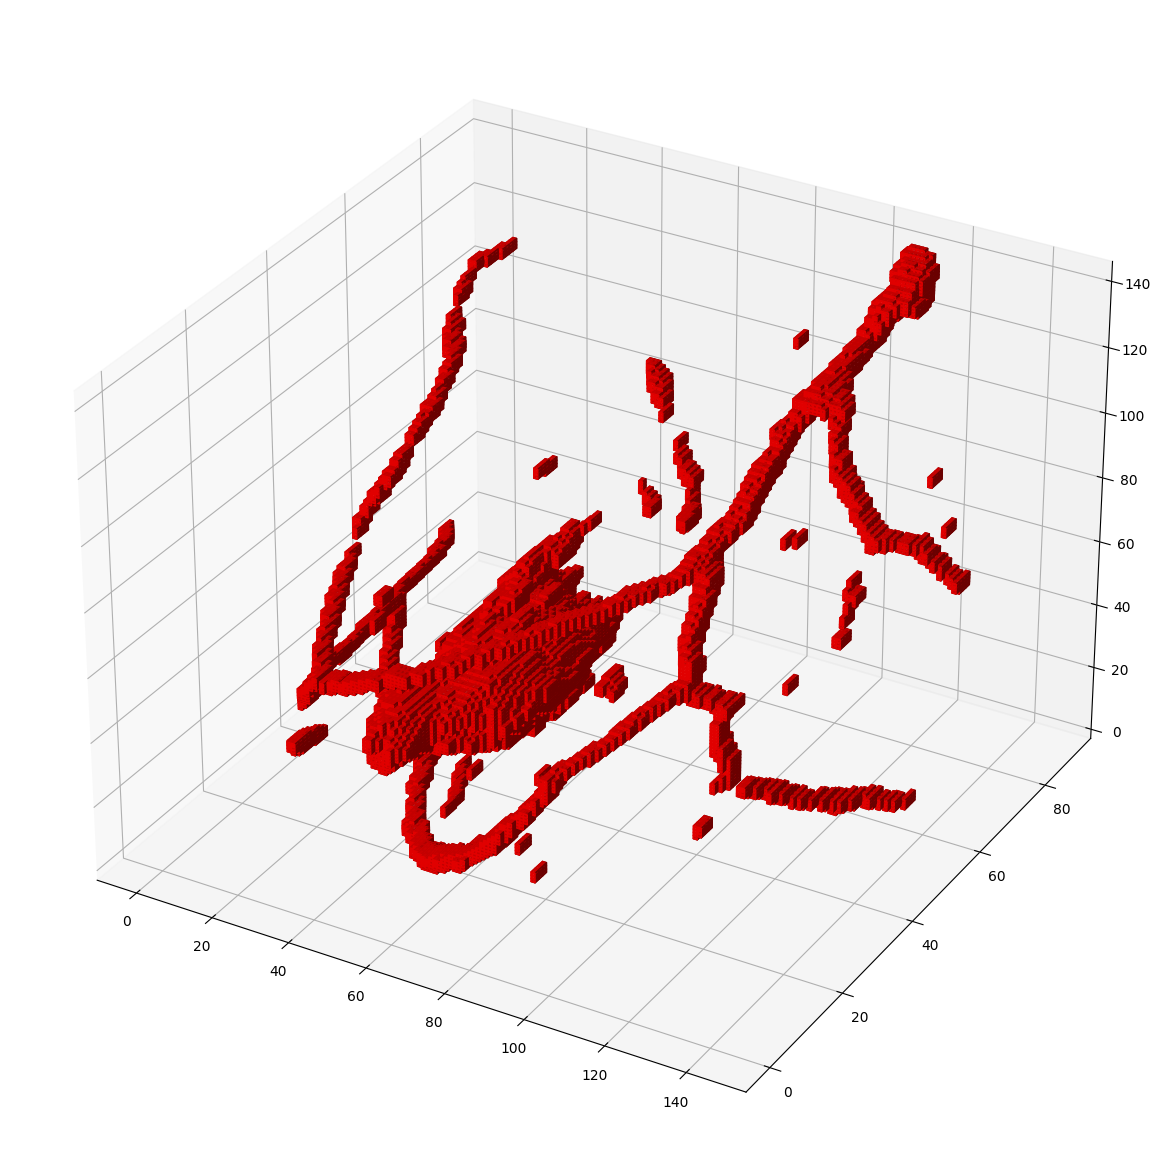

In [13]:
def visualize_bounding_volume(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Bounding Volume 내의 병변은 투명도를 높게 설정
    lesion_alpha = 0.7
    ax.voxels(
        lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1],
        edgecolors='r',
        facecolors='r',
        alpha=lesion_alpha
    )

    plt.show()

# 가장 큰 병변의 Bounding Volume을 시각화
visualize_bounding_volume(lesion_mask, min_corner, max_corner)  # lesion_mask를 입력으로 추가